# Train With Colbert

In [9]:
import os
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Optional, Union
from scipy.special import softmax
from pathlib import Path

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
from colbert import Indexer, Searcher

import wandb
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments, \
                         IntervalStrategy, get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers.utils.notebook import NotebookProgressCallback
from datasets import Dataset # HuggingFace
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

In [10]:
pl.Config(fmt_str_lengths=2000);

In [11]:
#!conda install -c conda-forge faiss-gpu -y

In [12]:
dfs = []
folder_path = './data/daniel_train/v_1/*'
columns = ['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4', 'title', 'section_title']

for csv_file in glob.glob(folder_path):
    df = pl.read_csv(csv_file)
    dfs.append(df[columns])

train_raw = pl.concat(dfs)\
              .filter(pl.col('question').is_not_null())
train_raw.shape, np.array(train_raw.columns)

((7649, 8),
 array(['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3',
        'incorrect_4', 'title', 'section_title'], dtype='<U13'))

In [13]:
# train_raw.write_parquet('./data/daniel_train/v_1_combined/daniel_train_v_1.parquet')

In [14]:
choices_np = train_raw[['correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4']].to_numpy()

n_rows, n_cols = choices_np.shape
shuffled_indices = np.array([np.random.permutation(n_cols) for _ in range(n_rows)])
shuffled_data = np.take_along_axis(choices_np, shuffled_indices, axis=1)
correct_positions = np.argmax(shuffled_data == choices_np[:, 0][:, np.newaxis], axis=1)

answer_map = np.array(['A', 'B', 'C', 'D', 'E'])
answers = answer_map[correct_positions]

choices = pl.DataFrame({
    'A': shuffled_data[:, 0].astype(str),
    'B': shuffled_data[:, 1].astype(str),
    'C': shuffled_data[:, 2].astype(str),
    'D': shuffled_data[:, 3].astype(str),
    'E': shuffled_data[:, 4].astype(str),
    'answer': answers
    },
    [(col, pl.Utf8) for col in ['A', 'B', 'C', 'D', 'E', 'answer']]
)

train = train_raw[['question','title', 'section_title']].with_columns(choices)

n_test2 = 500
test2 = train[train.shape[0] - n_test2:]
train = train[:train.shape[0] - n_test2]
print(train.shape[0], test2.shape[0])

7149 500


In [15]:
train_osmu = pl.read_csv('./data/6000_wiki_en_sci_questions_with_excerpts.csv') \
               .filter(pl.col('A').is_not_null())
train_osmu = train_osmu.rename({'prompt': 'question'})

test_osmu = train_osmu[train_osmu.shape[0]- n_test2:]
train_osmu = train_osmu[:train_osmu.shape[0]- n_test2]
train_osmu.shape, test_osmu.shape, train_osmu.columns

((5518, 8),
 (500, 8),
 ['question', 'A', 'C', 'B', 'D', 'E', 'answer', 'wikipedia_excerpt'])

In [16]:
test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")
test.columns

['question', 'A', 'B', 'C', 'D', 'E', 'answer']

## Retrieve Wiki Context via ColBERT

In [18]:
max_words = 100
nbits = 2
colbert_path = Path(f'./data/colbert_max_words_{max_words}_nbits_{nbits}-v4')
wiki_passages = pl.read_parquet(colbert_path/f'wiki_passages.parquet')
wiki_passages.columns

['passage_id',
 'section_id',
 'title',
 'section_title',
 'section_index',
 'passage_text',
 'title_section_rank']

In [19]:
word_counts = wiki_passages['passage_text'].str.split(' ').list.lengths()
assert max_words == word_counts.max()
word_counts.max()

100

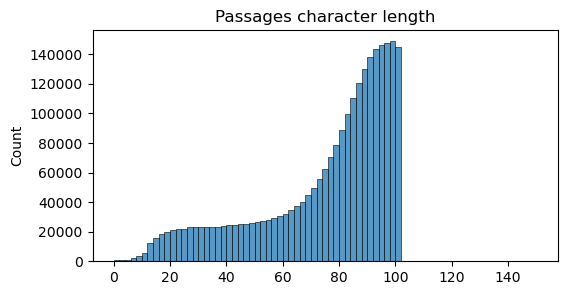

In [20]:
plt.figure(figsize=[6,3])
sns.histplot(word_counts, binrange=[0, 150], bins=75)
plt.title('Passages character length');

In [41]:
n_results_per_question = 1

#doc_maxlen = 160 # 512   # lenght in tokens
#dim = 128 # 128 is max for BERT

checkpoint = './checkpoints/colbertv2.0'

indexer_name = f'colbert_wiki_indexer'
#os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    #doc_maxlen=doc_maxlen,
    nbits=nbits
    #dim=dim
)

In [42]:
# num_ctx_cols = 1
# queries = test.with_row_count('qid')[['qid', 'question']]
# queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
# queries_file = './data/wiki_queries.tsv'
# queries.write_csv(queries_file, separator='\t', has_header=False)

# c_queries = Queries(queries_file)

# with Run().context(RunConfig(nranks=1,
#                              index_root=str(colbert_path))):
#     searcher = Searcher(index=indexer_name, 
#                         config=config,
#                         collection=str(colbert_path/f'wiki_passages_{max_words}.tsv'))
#     query = next(iter(c_queries.values()))
#     result = searcher.search(query, k=n_results_per_question)
#     match_ids, index, score = result

In [46]:
def add_q_colbert_context(data):
    num_ctx_cols = 1
    queries = data.with_row_count('qid')[['qid', 'question']]
    queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
    queries_file = './data/wiki_queries.tsv'
    queries.write_csv(queries_file, separator='\t', has_header=False)

    c_queries = Queries(queries_file)

    searcher = Searcher(index=indexer_name, 
                        config=config,
                        collection=str(colbert_path/f'wiki_passages.tsv'))
    ranking = searcher.search_all(c_queries, k=n_results_per_question)

    colbert_passage_ids = pl.DataFrame(pd.DataFrame(ranking.items()))
    colbert_passage_ids = colbert_passage_ids \
        .lazy() \
        .select([pl.col("1").list.get(i).list.get(0).alias(f"wiki_ctx_{i+1}").cast(pl.UInt32) for i in range(num_ctx_cols)]) \
        .collect()
    
    passages = wiki_passages[['passage_id', 'passage_text']]
    data_p = data.with_columns(colbert_passage_ids)
    for i in range(num_ctx_cols):
        data_p = data_p.join(passages, how='left', left_on=f'wiki_ctx_{i+1}', right_on='passage_id', validate='m:1', suffix=f'_{i+1}')
    return data_p

In [49]:
a_to_e = ['A', 'B', 'C', 'D', 'E']
score_col_prefix = 'answer_passage_score_'

def add_answer_colbert_context(data):
    n_results_per_question = 1
    
    for letter in a_to_e:
        answer_queries = data.with_row_count('qid')[['qid', letter]]
        answer_queries = answer_queries.with_columns(pl.col(letter).str.replace_all('\n', ' ')) 
        queries_file = './data/wiki_queries.tsv'
        answer_queries.write_csv(queries_file, separator='\t', has_header=False)

        col_a_queries = Queries(queries_file)

        searcher = Searcher(index=indexer_name, 
                            config=config,
                            collection=str(colbert_path/f'wiki_passages.tsv'))
        ranking = searcher.search_all(col_a_queries, k=n_results_per_question)

        ranking = pl.DataFrame(pd.DataFrame(ranking.items()))
        answer_passage_ids = ranking['1'].list.get(0).list.get(0)
        answer_scores = ranking['1'].list.get(0).list.get(2)

        id_col_name = f'passage_id_{letter}'
        score_col_name = f'{score_col_prefix}{letter}'
        data = data.with_columns(**{
            id_col_name: answer_passage_ids.cast(pl.UInt32),
            score_col_name: answer_scores
        })

        passages = wiki_passages[['passage_id', 'passage_text']]
        data = data.join(passages, how='left', left_on=id_col_name, right_on='passage_id', validate='m:1', suffix=f'_{letter}')
    return data
    
    
def add_best_answer(data):
    best_answer_matches = []
    best_answer_letters = []
    highscores = []
    for row in data.iter_rows(named=True):

        highest_score = 0
        highscore_letter = None
        for letter in a_to_e:
            score_col_name = f'{score_col_prefix}{letter}'
            if row[score_col_name] > highest_score:
                highest_score = row[score_col_name]
                highscore_letter = letter

        id_col_name = f'passage_text_{highscore_letter}'
        best_answer_matches.append(row[id_col_name])
        best_answer_letters.append(highscore_letter)
        highscores.append(highest_score)

    return data.with_columns(best_answer_match=pl.Series(best_answer_matches),
                             answer_score=pl.Series(highscores),
                             best_answer_letter=pl.Series(best_answer_letters))

In [50]:
rerun = True

enriched_cache_path = Path(f'./data/qa_context_{max_words}')
os.makedirs(enriched_cache_path, exist_ok=True)

def cached_add_q_colbert_context(data, file_name):
    file_path = enriched_cache_path/f'{file_name}.parquet'
    if file_path.exists() and not rerun:
        return pl.read_parquet(file_path)
    else:
        with Run().context(RunConfig(nranks=1,
                                    index_root=str(colbert_path))):
            with_context = add_q_colbert_context(data)
            with_context = add_answer_colbert_context(with_context)
        with_context = add_best_answer(with_context)
        torch.cuda.empty_cache()
        with_context.write_parquet(file_path)
        return with_context
    
train_p = cached_add_q_colbert_context(train, 'train')
train_osmu_p = cached_add_q_colbert_context(train_osmu, 'train_osmu')
test_p = cached_add_q_colbert_context(test, 'test')
test2_p = cached_add_q_colbert_context(test2, 'test2')
test_osmu_p = cached_add_q_colbert_context(test_osmu, 'test_osmu')

[Sep 22, 18:56:38] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 18:56:38] #> Got 7149 queries. All QIDs are unique.

[Sep 22, 18:56:38] #> Loading collection...
0M 1M 2M 
[Sep 22, 18:56:42] #> Loading codec...
[Sep 22, 18:56:42] #> Loading IVF...
[Sep 22, 18:56:43] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2928.42it/s]

[Sep 22, 18:56:43] #> Loading codes and residuals...



100%|██████████| 7149/7149 [00:51<00:00, 138.60it/s]


[Sep 22, 18:57:41] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 18:57:41] #> Got 7149 queries. All QIDs are unique.

[Sep 22, 18:57:41] #> Loading collection...
0M 1M 2M 
[Sep 22, 18:57:45] #> Loading codec...
[Sep 22, 18:57:45] #> Loading IVF...
[Sep 22, 18:57:45] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2835.92it/s]

[Sep 22, 18:57:45] #> Loading codes and residuals...



100%|██████████| 7149/7149 [01:36<00:00, 74.46it/s] 


[Sep 22, 18:59:28] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 18:59:28] #> Got 7149 queries. All QIDs are unique.

[Sep 22, 18:59:28] #> Loading collection...
0M 1M 2M 
[Sep 22, 18:59:32] #> Loading codec...
[Sep 22, 18:59:32] #> Loading IVF...
[Sep 22, 18:59:32] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2961.79it/s]

[Sep 22, 18:59:32] #> Loading codes and residuals...



100%|██████████| 7149/7149 [01:39<00:00, 72.15it/s] 


[Sep 22, 19:01:19] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:01:19] #> Got 7149 queries. All QIDs are unique.

[Sep 22, 19:01:19] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:01:23] #> Loading codec...
[Sep 22, 19:01:23] #> Loading IVF...
[Sep 22, 19:01:24] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2675.55it/s]

[Sep 22, 19:01:24] #> Loading codes and residuals...



100%|██████████| 7149/7149 [01:37<00:00, 73.08it/s]


[Sep 22, 19:03:09] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:03:09] #> Got 7149 queries. All QIDs are unique.

[Sep 22, 19:03:09] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:03:13] #> Loading codec...
[Sep 22, 19:03:13] #> Loading IVF...
[Sep 22, 19:03:13] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2607.79it/s]

[Sep 22, 19:03:13] #> Loading codes and residuals...



100%|██████████| 7149/7149 [01:40<00:00, 71.27it/s]


[Sep 22, 19:05:02] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:05:02] #> Got 7149 queries. All QIDs are unique.

[Sep 22, 19:05:02] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:05:06] #> Loading codec...
[Sep 22, 19:05:06] #> Loading IVF...
[Sep 22, 19:05:06] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2614.64it/s]

[Sep 22, 19:05:06] #> Loading codes and residuals...



100%|██████████| 7149/7149 [01:39<00:00, 72.10it/s]


[Sep 22, 19:06:54] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:06:54] #> Got 5518 queries. All QIDs are unique.

[Sep 22, 19:06:54] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:06:58] #> Loading codec...
[Sep 22, 19:06:58] #> Loading IVF...
[Sep 22, 19:06:58] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2636.84it/s]

[Sep 22, 19:06:58] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:47<00:00, 116.68it/s]


[Sep 22, 19:07:51] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:07:51] #> Got 5518 queries. All QIDs are unique.

[Sep 22, 19:07:51] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:07:55] #> Loading codec...
[Sep 22, 19:07:55] #> Loading IVF...
[Sep 22, 19:07:55] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2596.50it/s]

[Sep 22, 19:07:55] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:57<00:00, 95.97it/s] 


[Sep 22, 19:08:58] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:08:58] #> Got 5518 queries. All QIDs are unique.

[Sep 22, 19:08:58] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:09:02] #> Loading codec...
[Sep 22, 19:09:02] #> Loading IVF...
[Sep 22, 19:09:02] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2978.32it/s]

[Sep 22, 19:09:02] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:58<00:00, 94.03it/s] 


[Sep 22, 19:10:07] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:10:07] #> Got 5518 queries. All QIDs are unique.

[Sep 22, 19:10:07] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:10:10] #> Loading codec...
[Sep 22, 19:10:10] #> Loading IVF...
[Sep 22, 19:10:11] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2730.46it/s]

[Sep 22, 19:10:11] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:58<00:00, 95.01it/s] 


[Sep 22, 19:11:15] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:11:15] #> Got 5518 queries. All QIDs are unique.

[Sep 22, 19:11:15] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:11:18] #> Loading codec...
[Sep 22, 19:11:18] #> Loading IVF...
[Sep 22, 19:11:18] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2526.30it/s]

[Sep 22, 19:11:19] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:58<00:00, 93.82it/s] 


[Sep 22, 19:12:23] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:12:23] #> Got 5518 queries. All QIDs are unique.

[Sep 22, 19:12:23] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:12:27] #> Loading codec...
[Sep 22, 19:12:27] #> Loading IVF...
[Sep 22, 19:12:27] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2601.59it/s]

[Sep 22, 19:12:27] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:58<00:00, 94.67it/s] 


[Sep 22, 19:13:33] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:13:33] #> Got 200 queries. All QIDs are unique.

[Sep 22, 19:13:33] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:13:36] #> Loading codec...
[Sep 22, 19:13:36] #> Loading IVF...
[Sep 22, 19:13:37] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2628.16it/s]

[Sep 22, 19:13:37] #> Loading codes and residuals...



100%|██████████| 200/200 [00:01<00:00, 130.84it/s]


[Sep 22, 19:13:41] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:13:41] #> Got 200 queries. All QIDs are unique.

[Sep 22, 19:13:41] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:13:45] #> Loading codec...
[Sep 22, 19:13:45] #> Loading IVF...
[Sep 22, 19:13:45] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 1658.72it/s]

[Sep 22, 19:13:45] #> Loading codes and residuals...



100%|██████████| 200/200 [00:03<00:00, 63.06it/s]


[Sep 22, 19:13:51] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:13:51] #> Got 200 queries. All QIDs are unique.

[Sep 22, 19:13:51] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:13:54] #> Loading codec...
[Sep 22, 19:13:54] #> Loading IVF...
[Sep 22, 19:13:55] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2650.49it/s]

[Sep 22, 19:13:55] #> Loading codes and residuals...



100%|██████████| 200/200 [00:03<00:00, 63.53it/s]


[Sep 22, 19:14:01] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:14:01] #> Got 200 queries. All QIDs are unique.

[Sep 22, 19:14:01] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:14:05] #> Loading codec...
[Sep 22, 19:14:05] #> Loading IVF...
[Sep 22, 19:14:05] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2847.00it/s]

[Sep 22, 19:14:05] #> Loading codes and residuals...



100%|██████████| 200/200 [00:03<00:00, 62.39it/s]


[Sep 22, 19:14:11] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:14:11] #> Got 200 queries. All QIDs are unique.

[Sep 22, 19:14:11] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:14:15] #> Loading codec...
[Sep 22, 19:14:15] #> Loading IVF...
[Sep 22, 19:14:15] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2542.08it/s]

[Sep 22, 19:14:15] #> Loading codes and residuals...



100%|██████████| 200/200 [00:03<00:00, 63.24it/s]


[Sep 22, 19:14:22] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:14:22] #> Got 200 queries. All QIDs are unique.

[Sep 22, 19:14:22] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:14:25] #> Loading codec...
[Sep 22, 19:14:25] #> Loading IVF...
[Sep 22, 19:14:25] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2711.84it/s]

[Sep 22, 19:14:26] #> Loading codes and residuals...



100%|██████████| 200/200 [00:03<00:00, 63.30it/s]


[Sep 22, 19:14:32] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:14:32] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:14:32] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:14:36] #> Loading codec...
[Sep 22, 19:14:36] #> Loading IVF...
[Sep 22, 19:14:36] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2246.92it/s]

[Sep 22, 19:14:36] #> Loading codes and residuals...



100%|██████████| 500/500 [00:03<00:00, 133.41it/s]


[Sep 22, 19:14:42] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:14:42] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:14:42] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:14:46] #> Loading codec...
[Sep 22, 19:14:46] #> Loading IVF...
[Sep 22, 19:14:47] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 1701.95it/s]

[Sep 22, 19:14:47] #> Loading codes and residuals...



100%|██████████| 500/500 [00:07<00:00, 71.19it/s]


[Sep 22, 19:14:56] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:14:56] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:14:56] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:15:00] #> Loading codec...
[Sep 22, 19:15:00] #> Loading IVF...
[Sep 22, 19:15:00] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2796.81it/s]

[Sep 22, 19:15:01] #> Loading codes and residuals...



100%|██████████| 500/500 [00:06<00:00, 74.00it/s]


[Sep 22, 19:15:11] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:15:11] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:15:11] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:15:14] #> Loading codec...
[Sep 22, 19:15:14] #> Loading IVF...
[Sep 22, 19:15:14] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2588.02it/s]

[Sep 22, 19:15:15] #> Loading codes and residuals...



100%|██████████| 500/500 [00:06<00:00, 73.32it/s]


[Sep 22, 19:15:24] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:15:24] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:15:24] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:15:28] #> Loading codec...
[Sep 22, 19:15:28] #> Loading IVF...
[Sep 22, 19:15:28] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2566.49it/s]

[Sep 22, 19:15:28] #> Loading codes and residuals...



100%|██████████| 500/500 [00:06<00:00, 73.64it/s]


[Sep 22, 19:15:39] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:15:39] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:15:39] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:15:42] #> Loading codec...
[Sep 22, 19:15:43] #> Loading IVF...
[Sep 22, 19:15:43] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2720.08it/s]

[Sep 22, 19:15:43] #> Loading codes and residuals...



100%|██████████| 500/500 [00:06<00:00, 73.23it/s]


[Sep 22, 19:15:54] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:15:54] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:15:54] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:15:58] #> Loading codec...
[Sep 22, 19:15:58] #> Loading IVF...
[Sep 22, 19:15:58] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2430.36it/s]

[Sep 22, 19:15:58] #> Loading codes and residuals...



100%|██████████| 500/500 [00:04<00:00, 116.45it/s]


[Sep 22, 19:16:05] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:16:05] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:16:05] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:16:09] #> Loading codec...
[Sep 22, 19:16:09] #> Loading IVF...
[Sep 22, 19:16:09] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 1621.88it/s]

[Sep 22, 19:16:09] #> Loading codes and residuals...



100%|██████████| 500/500 [00:05<00:00, 90.30it/s] 


[Sep 22, 19:16:17] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:16:17] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:16:17] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:16:21] #> Loading codec...
[Sep 22, 19:16:21] #> Loading IVF...
[Sep 22, 19:16:21] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2777.83it/s]

[Sep 22, 19:16:22] #> Loading codes and residuals...



100%|██████████| 500/500 [00:05<00:00, 92.82it/s] 


[Sep 22, 19:16:30] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:16:30] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:16:30] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:16:34] #> Loading codec...
[Sep 22, 19:16:34] #> Loading IVF...
[Sep 22, 19:16:34] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2773.67it/s]

[Sep 22, 19:16:34] #> Loading codes and residuals...



100%|██████████| 500/500 [00:05<00:00, 90.96it/s] 


[Sep 22, 19:16:42] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:16:42] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:16:42] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:16:46] #> Loading codec...
[Sep 22, 19:16:46] #> Loading IVF...
[Sep 22, 19:16:46] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2626.79it/s]

[Sep 22, 19:16:47] #> Loading codes and residuals...



100%|██████████| 500/500 [00:05<00:00, 91.44it/s] 


[Sep 22, 19:16:56] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 22, 19:16:56] #> Got 500 queries. All QIDs are unique.

[Sep 22, 19:16:56] #> Loading collection...
0M 1M 2M 
[Sep 22, 19:17:00] #> Loading codec...
[Sep 22, 19:17:00] #> Loading IVF...
[Sep 22, 19:17:00] #> Loading doclens...


100%|██████████| 101/101 [00:00<00:00, 2615.79it/s]

[Sep 22, 19:17:00] #> Loading codes and residuals...



100%|██████████| 500/500 [00:05<00:00, 91.68it/s] 


In [51]:
with pl.Config(fmt_str_lengths=50):
    display(test_p[0])

question,A,B,C,D,E,answer,wiki_ctx_1,passage_text,passage_id_A,answer_passage_score_A,passage_text_A,passage_id_B,answer_passage_score_B,passage_text_B,passage_id_C,answer_passage_score_C,passage_text_C,passage_id_D,answer_passage_score_D,passage_text_D,passage_id_E,answer_passage_score_E,passage_text_E,best_answer_match,answer_score,best_answer_letter
str,str,str,str,str,str,str,u32,str,u32,f64,str,u32,f64,str,u32,f64,str,u32,f64,str,u32,f64,str,str,f64,str
"""Which of the following statements accurately desc…","""MOND is a theory that reduces the observed missin…","""MOND is a theory that increases the discrepancy b…","""MOND is a theory that explains the missing baryon…","""MOND is a theory that reduces the discrepancy bet…","""MOND is a theory that eliminates the observed mis…","""D""",1016568,"""Though MOND explains the anomalously great rotati…",2108576,101.125,"""Outstanding problems for MOND The most serious pr…",1016568,118.6875,"""Though MOND explains the anomalously great rotati…",2373339,101.625,"""Without observational constraints, there are a nu…",1016568,123.8125,"""Though MOND explains the anomalously great rotati…",2108576,115.875,"""Outstanding problems for MOND The most serious pr…","""Though MOND explains the anomalously great rotati…",123.8125,"""D"""


In [52]:
# test_osmu_p['passage_text'].str.split(' ').list.lengths().max()

## Prepare Train and Test for DeBERTa

In [53]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [54]:
max_length = 625

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None

    
    def __call__(self, input_batch):
        # input_batch is list of samples, choices, tokens
        additional_cols = set(input_batch[0].keys()) - set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        if len(additional_cols) > 0:
            print(f'{additional_cols=}')
        
        label_name = None
        if 'label' in input_batch[0].keys():
            label_name = 'label' 
            labels = [feature.pop(label_name) for feature in input_batch]
        batch_size = len(input_batch)
        num_choices = len(input_batch[0]['input_ids'])
        flattened_input = [
            [{k: v[i] for k, v in sample.items()} for i in range(num_choices)] for sample in input_batch
        ]
        flattened_input = sum(flattened_input, [])
        
        batch = self.tokenizer.pad(
            flattened_input,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors='pt',
        )
        
        # batch.shape = (n_samples, n_choices, n_tokens)
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        if label_name is not None:
            batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        #print(np.array(batch['input_ids']).shape)
        return batch

In [55]:
def preprocess(example):
    # adding the wikipedia page as context for the question by adding it after a [SEP] token to the question.
    first_sentence = [f"""{example['question']}
[SEP]{example['passage_text']}
[SEP]{example['best_answer_letter']}
[SEP]{example['best_answer_match']}
"""] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation='only_first', max_length=max_length)
    if 'answer' in example.keys():
        tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

def tokenized_dataset(data):
    columns_to_keep = set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
    dataset = Dataset.from_pandas(data.to_pandas(), preserve_index=False)
    col_to_remove = set(data.columns) - columns_to_keep
    tokenized = dataset.map(preprocess, remove_columns=col_to_remove)
    return tokenized

In [56]:
# tokenized_train = tokenized_dataset(train_p)
# tokenized_train_osmu = tokenized_dataset(train_osmu_p)
tokenized_test = tokenized_dataset(test_p)
tokenized_test2 = tokenized_dataset(test2_p)
tokenized_test_osmu = tokenized_dataset(test_osmu_p)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [57]:
cols = ['question', 'A', 'B', 'C', 'D', 'E', 'answer', 'passage_text', 'best_answer_match', 'best_answer_letter']
train_comb = pl.concat([
    train_p[cols],
    train_osmu_p[cols]
])
tokenized_train_comb = tokenized_dataset(train_comb)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

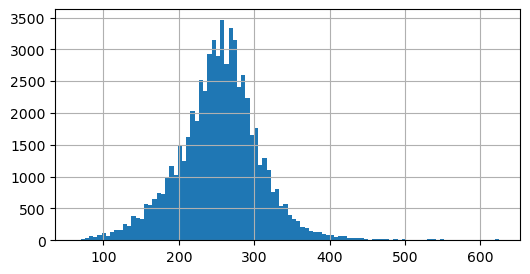

In [58]:
def plot_length_hist(tokenized_data):
    length_list = []
    for sample in tokenized_data['input_ids']:
        for option in sample:
            length_list.append(len(option))

    plt.figure(figsize=[6,3])
    pd.Series(length_list).hist(bins=100)
    
plot_length_hist(tokenized_train_comb)

## Train DeBERTa

In [59]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [60]:
retrain = True

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    learning_rate=5e-6,
    num_train_epochs=5,
    #fp16=True,
    #warmup_ratio=0.5,
    weight_decay=0,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=100,
    eval_steps=2000,
    save_steps=20000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='q_and_a_v4'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    
    # embedding_lr = 1e-8
    # early_layers_lr = 1e-7
    # middle_layers_lr = 1e-6
    # late_layers_lr = 2e-5
    # classifier_lr = 5e-5

#     optimizer_grouped_parameters = [
#         {'params': model.deberta.embeddings.parameters(), 'lr': embedding_lr},
#         {'params': model.deberta.encoder.layer[:8].parameters(), 'lr': early_layers_lr},
#         {'params': model.deberta.encoder.layer[8:16].parameters(), 'lr': middle_layers_lr},
#         {'params': model.deberta.encoder.layer[16:].parameters(), 'lr': late_layers_lr},
#         {'params': model.classifier.parameters(), 'lr': classifier_lr},
#     ]
    optimizer = AdamW(model.parameters(),
                      lr=training_args.learning_rate,
                      weight_decay=training_args.weight_decay)
                      #optimizer_grouped_parameters)
    
    total_steps = len(tokenized_train_comb) // training_args.per_device_train_batch_size * training_args.num_train_epochs
    #warmup_steps = int(total_steps * training_args.warmup_ratio)
    #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    scheduler = OneCycleLR(optimizer, max_lr=training_args.learning_rate, total_steps=total_steps)
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
        train_dataset=tokenized_train_comb,
        eval_dataset={
            'test': tokenized_test,
            'test_daniel': tokenized_test2,
            'test_osmu': tokenized_test_osmu
        },
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )

    # needed when there are multiple eval datasets
    trainer.remove_callback(NotebookProgressCallback)
    trainer.train()
    wandb.finish()
    trainer.save_model(output_path/training_args.run_name)
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/training_args.run_name)

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datadan. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/mambaforge/envs/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to m

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/test_accuracy,▁▂▅▇▄█▆████▆▇▇▇▇▆█▇▇▇▇██▇▇█▇▇▇▇
eval/test_daniel_accuracy,▁▂▄▆▂▇▇█▇▇▇▇▇▇▇█▇██▇▇▇▆█▇▇▇▇▇▇▇
eval/test_daniel_loss,█▃▂▁▂▂▁▁▂▂▂▂▃▂▃▂▃▄▄▅▄▅▇▄▄▅▅▅▅▅▅
eval/test_daniel_map_at_3,▁▁▄▆▃▇▇█▇▇▇█▇█▇█▇██▇█▇▇█▇▇▇▇▇▇▇
eval/test_daniel_runtime,█▁▂▅▃▃▂▂▃▃▃▂▂▁▃▃▅▃▃▂▄▂▂▂▂▃▃▃▃▂▂
eval/test_daniel_samples_per_second,▁█▇▄▆▆▇▆▆▆▆▇▇█▆▆▄▆▆▇▅▇▇▇▇▆▆▆▆▇▇
eval/test_daniel_steps_per_second,▁█▇▄▆▆▇▆▆▆▆▇▇█▆▆▄▆▆▇▅▆▇▇▇▆▆▆▆▆▇
eval/test_loss,█▄▃▂▂▁▂▁▁▁▁▂▃▂▄▃▃▂▃▃▄▄▄▃▃▄▄▄▄▄▄
eval/test_map_at_3,▁▁▆▇▄█▇████▇▇▇▇▇▆█▇▇▇▇██▇██████
eval/test_osmu_accuracy,▁▂▄▆▃▇▇▇▆█▇▇▇▇▇▇█▇█▇█▇▇████████
eval/test_osmu_loss,▂▁▁▁▂▂▂▂▂▂▂▂▅▃▄▃▃▅▄▄▅▆█▆▅▇▇▆▇▇▇


## Predict Test Set

In [61]:
trainer = Trainer(
    model=model,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
)

In [62]:
def predict_testset(test_with_passages, tokenized_testset):
    test_logits = trainer.predict(tokenized_testset).predictions
    test_preds = np.argsort(-test_logits, 1)
    test_letters = np.array(list('ABCDE'))[test_preds]
    test_letters = pl.Series(test_letters[:,:3]).list.join(' ')

    return test_with_passages.with_columns(all_prediction=test_letters, prediction=test_letters.str.slice(0,1))
    
test_pred = predict_testset(test_p, tokenized_test)

In [63]:
test_osmu_pred = predict_testset(test_osmu_p, tokenized_test_osmu)


### Osmu data notes
0. Based on the wikipedia_excerpt, the wrong answer is marked as correct.

In [ ]:
wiki_passages.filter(pl.col('title').str.contains('chloro'))

In [41]:
test_osmu_pred[1]

question,A,C,B,D,E,answer,wikipedia_excerpt,wiki_ctx_1,wiki_ctx_2,passage_text,passage_text_2,all_prediction,prediction
str,str,str,str,str,str,str,str,u32,u32,str,str,str,str
"""What is the structural relationship between chloroformic acid and formic acid?""","""Chloroformic acid is the single acyl-halide derivative of formic acid.""","""Chloroformic acid is the structurally similar derivative of formic acid.""","""Chloroformic acid is the stable derivative of formic acid.""","""Chloroformic acid is the chlorinated derivative of formic acid.""","""Chloroformic acid is the double acyl-halide derivative of formic acid.""","""A""","""Chloroformic acid: Chloroformic acid is an unstable chemical compound with the formula ClCO2H It is the single acyl-halide derivative of carbonic acid (phosgene is the double acyl-halide derivative) Chloroformic acid is also structurally related to formic acid, which has a hydrogen instead of the chlorine Despite the similar name, it is very different from chloroform Chloroformic acid itself is too unstable to be handled for chemical reactions""",130834,130837,"""Addition to alkenes Formic acid is unique among the carboxylic acids in its ability to participate in addition reactions with alkenes. Formic acids and alkenes readily react to form formate esters. In the presence of certain acids, including sulfuric acid and hydrofluoric acids, however, a variant of the Koch reaction occurs instead, and formic acid adds to the alkene to produce a larger carboxylic acid. Formic acid anhydride An unstable formic anhydride, H(C=O)−O−(C=O)H, can be obtained by dehydration of formic acid with N,N'-Dicyclohexylcarbodiimide in ether at low temperature.""","""Formic acid is unique among the carboxylic acids in its ability to participate in addition reactions with alkenes. Formic acids and alkenes readily react to form formate esters. In the presence of certain acids, including sulfuric acid and hydrofluoric acids, however, a variant of the Koch reaction occurs instead, and formic acid adds to the alkene to produce a larger carboxylic acid.""","""E A C""","""E"""


In [26]:
# test_output = pl.DataFrame({'prediction':test_letters}).with_row_count('id')
# test_output.write_csv('./data/submission.csv')

## Check Test predictions

In [27]:
check_test = test_p.with_columns(all_prediction=test_letters, prediction=test_letters.str.slice(0,1))

In [30]:
wrong = check_test#.filter(pl.col('answer') != pl.col('prediction'))
wrong = wrong.drop(['wiki_ctx_1', 'wiki_ctx_2'])
wrong[:4]

question,A,B,C,D,E,answer,passage_text,passage_text_2,all_prediction,prediction
str,str,str,str,str,str,str,str,str,str,str
"""Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed ""missing baryonic mass"" discrepancy in galaxy clusters?""","""MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called ""fuzzy dark matter.""""","""MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.""","""MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.""","""MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.""","""MOND is a theory that eliminates the observed missing baryonic mass in galaxy clusters by imposing a new mathematical formulation of gravity that does not require the existence of dark matter.""","""D""","""There have been a number of attempts to solve the problem of galaxy rotation by modifying gravity without invoking dark matter. One of the most discussed is modified Newtonian dynamics (MOND), originally proposed by Mordehai Milgrom in 1983, which modifies the Newtonian force law at low accelerations to enhance the effective gravitational attraction. MOND has had a considerable amount of success in predicting the rotation curves of low-surface-brightness galaxies, matching the baryonic Tully–Fisher relation, and the velocity dispersions of the small satellite galaxies of the Local Group. Using data from the Spitzer Photometry and Accurate Rotation Curves (SPARC) database, a group has found that the radial acceleration traced by rotation curves could be predicted just from the observed baryon distribution (that is, including stars and gas but not dark matter). The same relation provided a good fit for 2693 samples in 153 rotating galaxies, with diverse shapes, masses, sizes, and gas fractions. Brightness in the near infrared, where the more stable light from red giants dominates, was used to estimate the density contribution due to stars more consistently. The results are consistent with MOND, and place limits on alternative explanations involving dark matter alone.""","""MOND departs from Newton's laws at extremely small accelerations that are characteristic of the outer regions of galaxies as well as the inter-galaxy forces within galaxy clusters, but which are far below anything encountered in the Solar System or on Earth. unsolvedphysics What is the nature of dark matter? Is it a Elementary particle, or do the phenomena attributed to dark matter actually require a modification of the laws of gravity? MOND is an example of a class of theories known as modified models of gravity, and is an alternative to the hypothesis that the dynamics of galaxies are determined by massive, invisible dark matter halos. Since Milgrom's original proposal, proponents of MOND have claimed to successfully predict a variety of galactic phenomena that they state are difficult to understand as consequences of dark matter. Though MOND explains the anomalously great rotational velocities of galaxies at their perimeters, it does not fully explain the velocity dispersions of individual galaxies within galaxy clusters. MOND reduces the discrepancy between the velocity dispersions and clusters' observed missing baryonic mass from a factor of around 10 to a factor of about 2.""","""D E C""","""D"""
"""Which of the following is an accurate definition of dynamic scaling in self-similar systems?""","""Dynamic scaling refers to the evolution of self-similar systems, where data obtained fro

### Check Test Log
- The passages are often very similar or even contain duplications.
- Sometimes information from the answers could help make the passages more relevant.


0. Dynamic scaling: Incorrect context, picked answeres with incorrect negations before the correct answer
1. Triskeles: Incorrect context, no connection of context and question apparent
2. Regularization in terms of renomralization (physics): The context is useful, longer context might have been helpful. The answers differ in subtleties that the model does not get.
3. Gauss law, electic flux: The model seems to miss some subtle differences. The context is missing the formula.
4. Blocking tempereature of a spin valve: Context describes spin valves, but not the blocking temperature.